In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation
import pickle
import numpy as np
import networkx as nx
import seaborn as sns
from IPython.display import HTML

from saved files get:
- time series data
- environment
- final driver models

In [357]:
PATH = "experiments/symmetric_grid_S16/dqn_25_exploration_neighbours_iot_True_N100_dex-random_I100000_B64_EXP0.45_G0.9_LR0.01"

with open(f"{PATH}/data", "rb") as file:
    data = pickle.load(file)
# with open(f"{PATH}/drivers_pretrained", "rb") as file:
#     drivers = pickle.load(file)
with open(f"{PATH}/trips", "rb") as file:
    trips = pickle.load(file)
with open(f"{PATH}/trajectory", "rb") as file:
    trajectory = pickle.load(file)

In [358]:
travel_time = [data[t]["average_trip_time"] for t in data.keys()]

Text(0.5, 0, 'timestep')

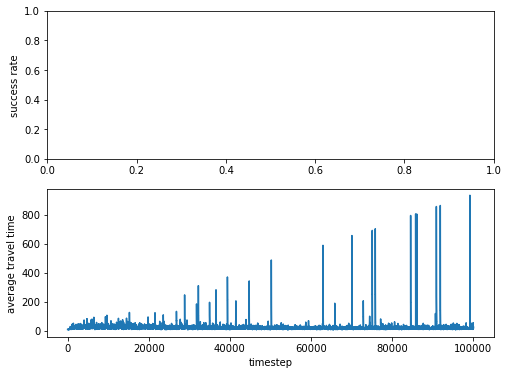

In [359]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
# ax[0].plot(success, color="red")
ax[0].set_ylabel("success rate")
ax[1].plot(travel_time)
ax[1].set_ylabel("average travel time")
ax[1].set_xlabel("timestep")
# plt.savefig("preliminary_results.png")

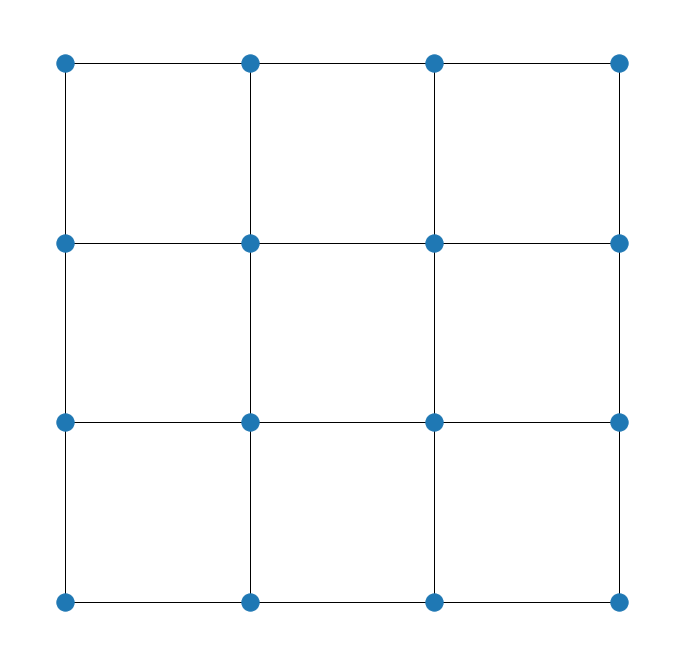

In [360]:
size = 4
G = nx.grid_graph(dim=(size, size))
for e in G.edges():
    G.edges[e]["cost"] = lambda x: 10 + x

positions = {node: node for node in G.nodes()}

fig, ax = plt.subplots(figsize=(12, 12))
nx.draw(G, pos=positions, ax=ax)
# plt.savefig("empty_grid.png")
plt.show()

In [361]:
# episodes = [data[t]["trajectory"] for t in data.keys()]

In [362]:
states_counts = []
edges_actions = []
destinations_counts = []
n_agents = 100

for experience in trajectory:
    states_counts.append(experience[1])
    edges_actions.append(experience[2])
    destinations_counts.append(experience[-1])

In [363]:
def update(num):
#     num = len(states_counts)-1000+num

    ax.clear()
    occupied_states = states_counts[num].keys()
    occupied_states_counts = states_counts[num].values()
    destinations = destinations_counts[num]
    
    nodes = set(G.nodes())
    occ_s = set([tuple(s) for s in occupied_states])
    destination_alphas = [counts/n_agents for counts in destinations.values()]
    destinations = set([tuple(s) for s in destinations.keys()])
    
    
    node_labels = states_counts[num]
    edgelist = edges_actions[num].keys()
    edge_labels = edges_actions[num]
    
    # Background nodes
    nx.draw_networkx_edges(G, pos=positions, ax=ax, edge_color="gray")
    null_nodes = nx.draw_networkx_nodes(G, pos=positions, nodelist=nodes - occ_s, 
                                        node_color="white", ax=ax)
    null_nodes.set_edgecolor("black")
    destination_nodes = nx.draw_networkx_nodes(G, pos=positions, nodelist=destinations, 
                                               node_color="green", alpha=destination_alphas, ax=ax)
    destination_nodes.set_edgecolor("green")
    
    # Query nodes
    query_nodes = nx.draw_networkx_nodes(
        G, 
        pos=positions, 
        nodelist=occ_s,
        node_size=1500,
        node_color=[node_labels[node] for node in occ_s],
        cmap="inferno_r",
        vmin=0,
        vmax=100,
        ax=ax)
    query_nodes.set_edgecolor("white")
    nx.draw_networkx_labels(G, pos=positions, labels=node_labels, font_size = 15, font_color="black", ax=ax)
    
    # Traversed edges
    nx.draw_networkx_edges(G, 
                           pos=positions, 
                           edgelist=edgelist,
                           ax=ax)
    nx.draw_networkx_edge_labels(G, 
                           pos=positions, 
                           edge_labels=edge_labels,
                           ax=ax)

    ax.set_xticks([])
    ax.set_yticks([])

In [364]:
ani = matplotlib.animation.FuncAnimation(fig, update, frames=100, interval=50, repeat=True)
HTML(ani.to_jshtml())

In [365]:
ani.save('test.mp4')

### Pre-process trips

In [366]:
travel_times = {}
travel_steps = {}
max_step = 0
for agent, trip in trips.items():
    trip_time = np.array([metrics[1] for metrics in trip]).flatten()  #extract the travel time
    trip_step = np.array([metrics[0] for metrics in trip]).flatten().astype(int)  #extract the steps
    trip_freeflow_length = np.abs(np.diff(np.array([metrics[2] for metrics in trip[1:]]), axis=0).sum(axis=1).sum(axis=1))
    trip_freeflow_length = np.concatenate([np.array([6]), trip_freeflow_length])
    normalization = np.where(trip_freeflow_length==0, 2, trip_freeflow_length)
    max_step = max(max_step, trip_step[-1])
    travel_times[agent] = np.diff(trip_time)/normalization
    travel_steps[agent] = trip_step[1:]

/var/folders/11/3vmp2wls5_xb0s9pfn4zdp580000gq/T/ipykernel_89597/3794466067.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trip_step = np.array([metrics[0] for metrics in trip]).flatten().astype(int)  #extract the steps


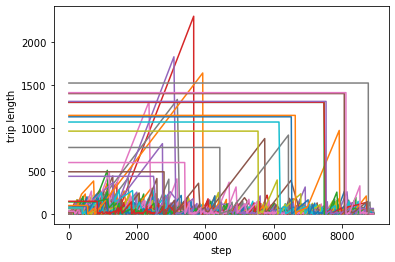

In [367]:
x = np.arange(0, max_step)
Y = np.zeros((n_agents, int(max_step)))
for agent, times in travel_times.items():
    y = np.interp(x, travel_steps[agent], times)
    Y[agent, :] = y
    plt.plot(x, y)
    
plt.ylabel("trip length")
plt.xlabel("step")
plt.savefig(f"{PATH}/trip_lengths_timeseries.png")

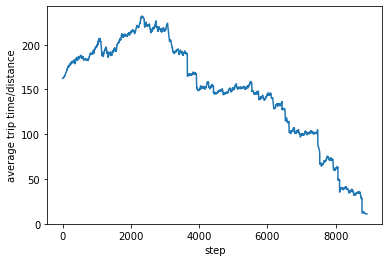

In [368]:
plt.plot(Y.mean(axis=0))
plt.ylabel("average trip time/distance")
plt.xlabel("step")
plt.savefig(f"{PATH}/system_performance_timeseries.png")

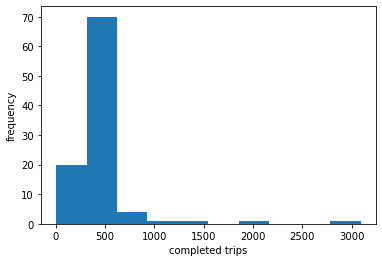

In [369]:
plt.hist([len(steps) for steps in travel_times.values()])
plt.ylabel("frequency")
plt.xlabel("completed trips")
plt.savefig(f"{PATH}/completed_trips_histogram.png")

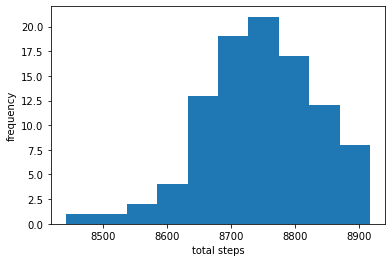

In [370]:
plt.hist([steps[-1] for steps in travel_steps.values()])
plt.ylabel("frequency")
plt.xlabel("total steps")
plt.savefig(f"{PATH}/trip_length_histogram.png")

### Visits Heatmaps

In [5]:
## plot heatmap of state visits for initial and final agents
early_episode = data[10]["trajectory"]
late_episode = data[999]["trajectory"]

early_visits = np.zeros((4, 4))
for experience in early_episode:
    for k, v in experience[1].items():
        early_visits[k[0], k[1]] += v

late_visits = np.zeros((4, 4))
for experience in late_episode:
    for k, v in experience[1].items():
        late_visits[k[0], k[1]] += v

        
fig, ax = plt.subplots(ncols=2, figsize=(12, 12))
ax[0].imshow(early_visits, origin="lower")
ax[1].imshow(late_visits, origin="lower")

ax[0].set_yticks([])
ax[1].set_yticks([])

ax[0].set_xticks([])
ax[1].set_xticks([])

ax[0].set_title("early training step")
ax[1].set_title("last training step")

plt.tight_layout()
plt.savefig("visits_heatmap")

KeyError: 'trajectory'

## Visualize Driver Q-Values

In [ ]:
import torch

In [ ]:
drivers[0].policy_net(torch.tensor([0,0,0,1,0,0,0,1,0.5], dtype=torch.float32))

In [ ]:
one_hot_enc = {(l, r): np.concatenate([
    np.array([0 if i != l else 1 for i in range(size)]), 
    np.array([0 if i != r else 1 for i in range(size)])
]) for(l, r) in G.nodes()}

In [ ]:
avg_values = np.zeros((size, size, 1))
var_values = np.zeros((size, size, 1))

In [ ]:
for i in range(size):
    for j in range(size):
        values = torch.zeros((100, 4))
        for n, driver in drivers.items():
            values[n] = driver.policy_net(torch.tensor(
                one_hot_enc[i, j], dtype=torch.float32))
        avg_values[i, j] = values.numpy(force=True).mean()
        var_values[i, j] = values.numpy(force=True).var(axis=0).mean()

In [ ]:
plt.imshow(avg_values, origin="lower")
plt.colorbar()

In [ ]:
plt.imshow(var_values, origin="lower")
plt.colorbar()

In [ ]:
edge_action_values = dict()
for node in G.nodes():
    values = torch.zeros((100, 4))
    for n, driver in drivers.items():
        values[n] = driver.policy_net(torch.tensor(
            one_hot_enc[node], dtype=torch.float32))
    values = values.numpy(force=True)
    for action, edge in enumerate(G.edges(node)):
        edge_action_values[edge] = values[:,action]

In [ ]:
edge_labels = {}
for edge, action_values in list(edge_action_values.items()):
    x0, x1 = edge
    if sum(x0) > sum(x1):
        x0_x1_values = action_values.mean()
        x1_x0_values = edge_action_values[(x1, x0)].mean()
        edge_labels[(x1, x0)] = f"{-1*x0_x1_values:.2f} ---- {-1*x1_x0_values:.2f}"

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw(G, pos=positions, ax=ax)
nx.draw_networkx_edge_labels(G, 
                           pos=positions, 
                           edge_labels=edge_labels,
                           ax=ax,
                            font_size=15)
plt.show()

In [ ]:
from collections import defaultdict

In [ ]:
a = {0: 0}
defaultdict(lambda: 0, a)

In [ ]:
list(G.edges((0,0))) + list(G.edges((0,1)))

## Sandbox

In [287]:
# generate work-commute OD pairs
N_AGENTS = 10
work_commute_destinations = {}
for n in range(N_AGENTS):
    origin = np.random.randint(0, 4, size=2)
    destination = np.random.randint(0, 4, size=2)
    
    while (origin == destination).all():
        destination = np.random.randint(0, 4, size=2)
        
    work_commute_destinations[n] = [origin, destination]

In [288]:
work_commute_destinations

{0: [array([1, 0]), array([3, 2])],
 1: [array([1, 0]), array([3, 2])],
 2: [array([0, 0]), array([1, 3])],
 3: [array([2, 0]), array([0, 2])],
 4: [array([1, 0]), array([1, 2])],
 5: [array([3, 2]), array([1, 3])],
 6: [array([1, 1]), array([0, 1])],
 7: [array([1, 3]), array([2, 3])],
 8: [array([3, 1]), array([1, 1])],
 9: [array([0, 1]), array([0, 0])]}

In [289]:
work_commute_destinations[0].pop()

array([3, 2])

In [285]:
a = []
a.append(1)